In [1]:
import numpy as np
import pandas as pd  
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from multilevelmodel.model import MultiLevelModel

In [2]:
def generate_dummy_data(n_rows=5000):
    
    np.random.seed(42)
    
    data = {
        'Month': np.random.randint(1, 4, n_rows),       
        'Hour': np.random.randint(1, 25, n_rows),      
        'Weekend': np.random.choice([0, 1], n_rows, p=[0.7, 0.3]),
        'Holiday': np.random.choice([0, 1], n_rows, p=[0.95, 0.05]), 
        'PUN_Ratio': np.random.uniform(0.5, 2.0, n_rows) 
    }
    
    df = pd.DataFrame(data)

    def calculate_shape(row):
        h = row['Hour']
        weekend = row['Weekend'] == 1
        
        # Base coefficients for Duck Curve: [base_shape, slope]
        if 11 <= h <= 15:    # Mid-day drop (Solar generation)
            coeffs = [0.6, 0.05]
        elif 18 <= h <= 21:  # Evening ramp (The "Neck")
            coeffs = [1.4, 0.8] 
        elif 7 <= h <= 9:    # Morning peak
            coeffs = [1.1, 0.4]
        else:                # Base load / Night
            coeffs = [0.9, 0.1]
    
        # Weekend adjustment: lower demand, deeper belly
        if weekend:
            coeffs[0] -= 0.1
            if 11 <= h <= 15:
                coeffs[0] -= 0.1
    
        noise = np.random.normal(0, 0.2)
        return max(0.0, coeffs[0] + (coeffs[1] * row['PUN_Ratio']) + noise)

    df['Shape_Target'] = df.apply(calculate_shape, axis=1)
    
    return df

In [3]:
# fallback logic
def my_fallback_logic(key_tuple, groups):

    d = dict(zip(groups, key_tuple))
    
    if d['Holiday'] == 1 and d['Weekend'] == 0:
        print(f"Fallback for {key_tuple} -> finding Weekend=1")

        new_vals = [
            d['Month'],
            1,            # Forziamo Weekend = 1
            1,            # Manteniamo Holiday = 1
            d['Hour']
        ]
        return tuple(new_vals)
    return None

Training model...


Input X: 1.30, Target: 0.32, Predicted: 0.68


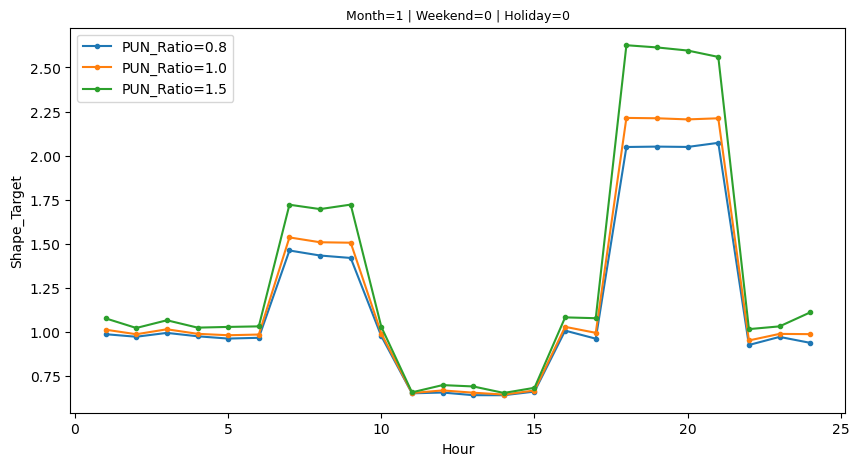

In [4]:
df = generate_dummy_data(10000)

model = MultiLevelModel(
    base_regressor = Ridge(alpha = 0.01),
    groups=["Month", "Weekend", "Holiday", "Hour"], 
    x_col="PUN_Ratio",
    target="Shape_Target",
    min_obs = 1,
    fallback_strategy=my_fallback_logic
)

print("Training model...")
model.fit(df)

sample_row = df.iloc[0]
pred = model.predict_row(sample_row)
print(f"\n\nInput X: {sample_row['PUN_Ratio']:.2f}, Target: {sample_row['Shape_Target']:.2f}, Predicted: {pred:.2f}")

model.plot_profile(
    profile_axis_col="Hour",
    filters={"Month": 1, "Weekend": 0, "Holiday": 0},
    x_col_values=[0.8, 1.0, 1.5] 
)

plt.show()


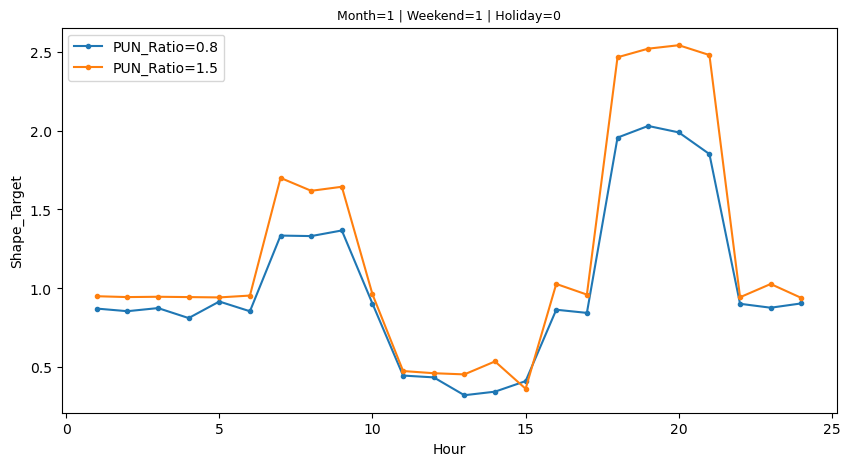

In [5]:
model.plot_profile(
    profile_axis_col="Hour",
    filters={"Month": 1, "Weekend": 1, "Holiday": 0},
    x_col_values=[0.8, 1.5]
)
plt.show()

Generating grid: 3 Rows (Month) x 4 Cols (['Weekend', 'Holiday'])...


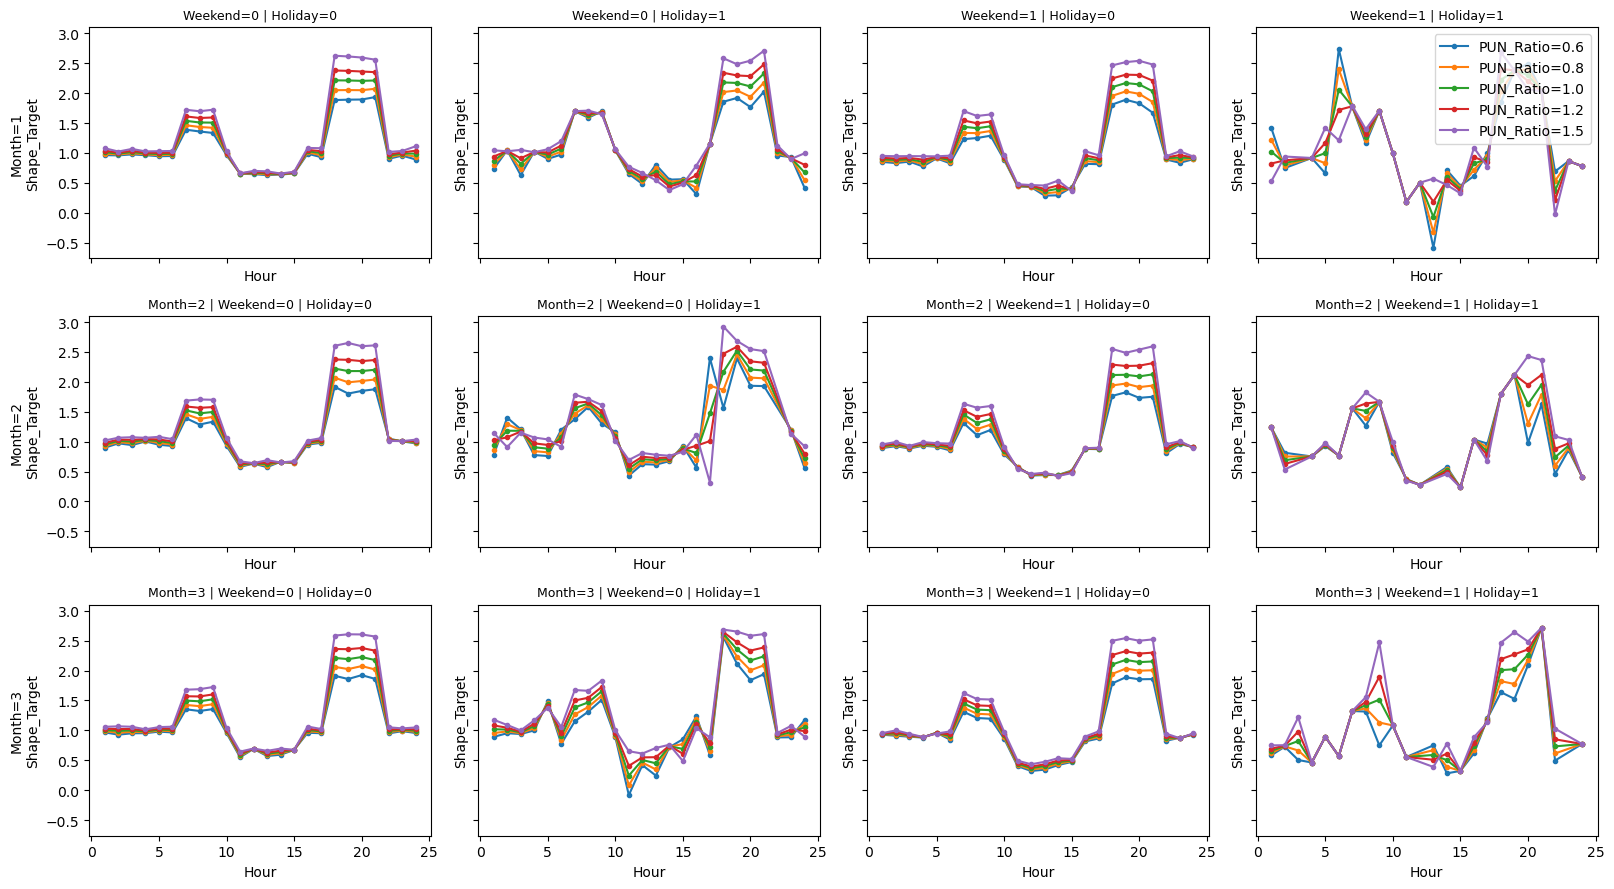

In [6]:
 model.plot_facet_grid(
    grid_row_group="Month",              # Rows of the grid
    grid_col_groups=["Weekend", "Holiday"], # Columns of the grid
    x_axis_col="Hour",                   # The X-axis of the plots
    x_col_values=[0.6, 0.8, 1.0, 1.2, 1.5]
)